# Topic modelling for Dreamachine dataset : High Sensory (HS) condition


Author : Romy Beauté\
Date created : 13/05/2024\
Last modified : 04/11/2024\
Corresp : r.beaut@sussex.ac.uk

Selection of sentence transformer embedding models :
https://www.sbert.net/docs/pretrained_models.html

The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality



In [1]:
%%capture
!pip install bertopic accelerate bitsandbytes xformers adjustText
!pip install llama-cpp-python
!{sys.executable} -m pip install "scipy==1.9.0" "scikit-image==0.23.2"

import os
import nltk
import sys
import pandas as pd

current_dir = os.getcwd()  # should be in NOTEBOOKS
lyra_dir = os.path.abspath(os.path.join(current_dir, '..'))  # go up one level
print("Lyra directory:", lyra_dir)


# Change directory and update path
os.chdir(lyra_dir)
sys.path.insert(0, lyra_dir)
print("Current working directory:", os.getcwd())
print("Python path first entry:", sys.path[0])


from grid_search_colyra import *
from META_helpers_colyra import split_sentences,reduced_custom_stopwords


os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')


condition = "HS" 
sentences = True
reduced_GS = False
random_seed = 42
nr_topics = "auto" 



results_GS = pd.read_csv(f'/home/romy/lyra/RESULTS/grid_search_results_{condition}_seed42{"_sentences" if sentences else ""}{"_reduced" if reduced_GS else ""}.csv')

reports_path = os.path.join("DATA",f"{condition}_reflections_cleaned.csv")
df_reports = pd.read_csv(reports_path,sep="\t")['reflection_answer']


if sentences:
    df_reports = split_sentences(df_reports)


In [2]:
# # #only print the results that have between 10 and 25 number of topics
# results_GS = results_GS[results_GS['n_topics']<=25]
# results_GS = results_GS[results_GS['n_topics']>=10]
# results_GS = results_GS.sort_values(by='coherence_score',ascending=False)



results_GS.head(5)

n_components  n_neighbors  min_dist  min_cluster_size  min_samples  \
0            20           10      0.00                 5            5   
1            10           10      0.01                 5            5   
2            10           10      0.05                 5            5   
3            11           25      0.00                 5            5   
4             8           25      0.05                 5            5   

   top_n_words  coherence_score  cohenrece_score_umass  n_topics  
0            5         0.544046              -8.584155        20  
1            5         0.539967              -8.477483        19  
2            5         0.520395              -9.251760        20  
3            5         0.517514              -9.065032        19  
4            5         0.507955              -9.299547        16

In [3]:
chosen_params = results_GS.iloc[0]
chosen_params


n_components             20.000000
n_neighbors              10.000000
min_dist                  0.000000
min_cluster_size          5.000000
min_samples               5.000000
top_n_words               5.000000
coherence_score           0.544046
cohenrece_score_umass    -8.584155
n_topics                 20.000000
Name: 0, dtype: float64

In [4]:
sentence_transformer_model = "all-mpnet-base-v2" #"paraphrase-MiniLM-L6-v2"# #"BAAI/bge-small-en" "all-MiniLM-L6-v2'"
embedding_model = SentenceTransformer(sentence_transformer_model)
embeddings = embedding_model.encode(df_reports, show_progress_bar=True)
print(embedding_model)

vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words=list(stopwords.words('english')),max_df=0.9,min_df=2)#+list(reduced_custom_stopwords)) #ngram_range=(1,2) : unigrams and bigrams

n_neighbors = int(chosen_params['n_neighbors'])
n_components = int(chosen_params['n_components'])
min_dist = float(chosen_params['min_dist'])
min_cluster_size = int(chosen_params['min_cluster_size'])
min_samples= int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
top_n_words = int(chosen_params['top_n_words'])
nr_topics = "auto"



metric='cosine'

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [5]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, metric='cosine', random_state=random_seed).fit_transform(embeddings)

umap_model = UMAP(n_neighbors=n_neighbors,
                  n_components=n_components,
                  min_dist=min_dist,
                  metric=metric,
                  random_state=random_seed) # rdm seed for reportability

hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size,
                        min_samples=min_samples,
                        gen_min_span_tree=True,
                        prediction_data=True)


In [6]:
model = BERTopic(
    umap_model=umap_model,
    low_memory=True,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=top_n_words,
    nr_topics= nr_topics,#default to None
    language='english',
    calculate_probabilities=True,
    verbose=True)

topics,_ = model.fit_transform(df_reports)

coherence_score,coherence_score_umass = calculate_coherence(model, df_reports) #sanitary check for coherence, that we obtain the same score as when running GS
print("Coherence Score:", coherence_score)

print(f"n = {len(np.unique(topics))} topics extracted")


#check how many documents identified as outliers
print(len(model.hdbscan_model.labels_[model.hdbscan_model.labels_==-1]))

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Topics: [['experience', 'felt', 'relaxed', 'interesting', 'felt relaxed'], ['felt', 'space', 'like', 'flying', 'felt like'], ['peace', 'calm', 'joy', 'relaxation', 'sense'], ['colors', 'red', 'kaleidoscope', 'color', 'black'], ['vision', 'front', 'also', 'eyes', 'lights'], ['geometric', 'shapes', 'patterns', 'dots', 'geometric shapes'], ['music', 'sound', 'created', 'throughout', 'movement'], ['thought', 'mind', 'aware', 'thoughts', 'started'], ['would', 'could', 'wish', 'would like', 'try'], ['stars', 'saw', 'rapidly', 'saw stars', 'planets'], ['death', 'life', 'like', 'back', 'felt like'], ['journey', 'forward', 'complete', 'varying', 'towards something'], ['asleep', 'awake', 'put', 'whether', 'opened eyes'], ['drugs', 'potential', 'psychedelic', 'perhaps', 'emotional'], ['colors', 'many', 'within', 'colors shapes', 'eye'], ['memories', 'beautiful', 'back', 'remembered', 'rainbow'], ['patterns made', 'back', 'focused', 'patterns', 'made'], ['shapes', 'pink', 'moving', 'geometric', 's

In [ ]:
#check sentences identified as outliers
# outliers = np.where(model.hdbscan_model.labels_==-1)[0]
# for i in outliers:
#     print(df_reports[i])


In [7]:
new_topics = model.reduce_outliers(df_reports, topics, strategy="embeddings",threshold=0.4)

# Check the impact
print(f"Original outliers: {len(model.hdbscan_model.labels_[model.hdbscan_model.labels_==-1])}")
print(f"Remaining outliers after reduction: {len([t for t in new_topics if t == -1])}")

#print the sentences that are identified as outliers after reduction
outliers = np.where(np.array(new_topics)==-1)[0]
for i in outliers:
    print(df_reports[i])

# Verify coherence is maintained
model.topics_ = new_topics
coherence_score, coherence_score_umass = calculate_coherence(model, df_reports)
print(f"New coherence score: {coherence_score:.4f}")

Original outliers: 153
Remaining outliers after reduction: 35
A Flock of birds.
vast.
And then maybe backwards.
Then really fast.
immense.
it was possible to generate full images on demand - elephant made of upwards flowing oil rivulets
moving through a tunnel of branches
no green I did not see any green at all from start to finish
Sometimes verging on oppressive, but never scary.
phosphorescence on water.
a Welsh blanket.
I am beyond words...
Figures standing as though about to dance.
sometimes I would see clips eg like from a film interspersed every now and again
A vast desert of dunes.
A summer meadow.
what do I really understand?
brains, neurons, veins, elephants,
Saw x3 distinct images:
1.
Treasure Chests (x2 Opening, x1 Closed/Locked)
3.
there were lots of children playing with their parents, throwing balls in the air.
various characters who if focused on them would disappear.
at the end when everything calmed down I saw a person amongst the white in a hospital bed.
Felt like the

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Topics: [['experience', 'felt', 'relaxed', 'interesting', 'felt relaxed'], ['felt', 'space', 'like', 'flying', 'felt like'], ['peace', 'calm', 'joy', 'relaxation', 'sense'], ['colors', 'red', 'kaleidoscope', 'color', 'black'], ['vision', 'front', 'also', 'eyes', 'lights'], ['geometric', 'shapes', 'patterns', 'dots', 'geometric shapes'], ['music', 'sound', 'created', 'throughout', 'movement'], ['thought', 'mind', 'aware', 'thoughts', 'started'], ['would', 'could', 'wish', 'would like', 'try'], ['stars', 'saw', 'rapidly', 'saw stars', 'planets'], ['death', 'life', 'like', 'back', 'felt like'], ['journey', 'forward', 'complete', 'varying', 'towards something'], ['asleep', 'awake', 'put', 'whether', 'opened eyes'], ['drugs', 'potential', 'psychedelic', 'perhaps', 'emotional'], ['colors', 'many', 'within', 'colors shapes', 'eye'], ['memories', 'beautiful', 'back', 'remembered', 'rainbow'], ['patterns made', 'back', 'focused', 'patterns', 'made'], ['shapes', 'pink', 'moving', 'geometric', 's

In [8]:
topics = new_topics
_, probabilities = model.transform(df_reports)

print(f"Number of unique topics after update: {len(np.unique([t for t in topics if t != -1]))}")
print(f"Number of remaining outliers: {len([t for t in topics if t == -1])}")


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Number of unique topics after update: 19
Number of remaining outliers: 35


In [9]:
model.visualize_barchart(title=f'Topic Word Scores for {condition}',autoscale=True)

In [10]:
model.visualize_documents(df_reports,title=f'Documents and Topics for {condition}')

# LLAMA 3

In [11]:
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
# # !wget https://huggingface.co/TheBloke/zephyr-7B-alpha-GGUF/resolve/main/zephyr-7b-alpha.Q4_K_M.gguf

# # DataMapPlot
# !git clone https://github.com/TutteInstitute/datamapplot.git
# !pip install datamapplot/.

import datamapplot
import torch
torch.cuda.empty_cache()

# # Remove existing installations
# !pip uninstall -y cudf cuml cugraph cupy rmm

# Install RAPIDS packages in correct order
!pip install --upgrade rmm-cu12 --extra-index-url=https://pypi.nvidia.com/simple
!pip install --upgrade cudf-cu12 --extra-index-url=https://pypi.nvidia.com/simple
!pip install --upgrade cuml-cu12 --extra-index-url=https://pypi.nvidia.com/simple

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com/simple
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com/simple
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com/simple


In [12]:
from huggingface_hub import hf_hub_download  # For loading the model instance from Hugging Face
import os  # For creating system directories
from llama_cpp import Llama  # LLM Wrapper
from bertopic.representation import KeyBERTInspired, LlamaCPP  # Representation Comparison
from sentence_transformers import SentenceTransformer  # Embedding Model Wrapper

from bertopic import BERTopic  # For topic modeling with BERTopic
import PIL  # For image processing
import numpy as np  # For numerical computations
import requests  # For making HTTP requests
import re  # For regular expressions


#to speed up computation
import torch
torch.cuda.empty_cache()
from cuml.manifold import UMAP  # For UMAP dimensionality reduction
from cuml.cluster import HDBSCAN  # For clustering with HDBSCAN

#add periodic memory clearing (use if too slow to run)
def process_batch(batch):
    results = []
    for item in batch:
        results.append(process_item(item))
        if len(results) % 100 == 0:  # Clear memory every 100 items
            torch.cuda.empty_cache()
    return results


In [13]:
model_name_or_path = "NousResearch/Meta-Llama-3-8B-Instruct-GGUF"
model_basename = "Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
os.makedirs('model', exist_ok=True)
path = "model"


# Downloading the model from repo
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename, cache_dir=path)

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"],verbose=False)

In [14]:



prompt = """Q:
Topic documents:
[DOCUMENTS]

Topic keywords: '[KEYWORDS]'

Create a specific, scientific label for this topic based on the above information. The label should:

1. Use proper spacing between words
2. Use Title Case (capitalize each significant word)
3. Not start or end with spaces
4. Focus on the core concept rather than methodology
5. Be a complete title (not cut off mid-word or mid-idea)
6. Be scientifically accurate
7. Do not use overly complex terminology
8. Be concise yet comprehensive (preferably 3-7 words)
9. Maintain operationalisability for research purposes

Only return the label itself, without any additional text or punctuation.
A:
"""


representation_model = {
   "KeyBERT": KeyBERTInspired(),
   "LLM": LlamaCPP(llm, prompt=prompt),
}


In [15]:
torch.cuda.empty_cache()

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
  nr_topics = nr_topics,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(df_reports,embeddings)



100%|██████████| 20/20 [01:09<00:00,  3.48s/it]


In [18]:
# outlier reduction using embeddingd
new_topics = topic_model.reduce_outliers(df_reports, topics,strategy='embeddings',threshold=0.4)

# Check the impact
print(f"Original outliers: {len(topic_model.hdbscan_model.labels_[topic_model.hdbscan_model.labels_==-1])}")
print(f"Remaining outliers after reduction: {len([t for t in new_topics if t == -1])}")

topic_model.topics_ = new_topics

topics = new_topics


Original outliers: 153
Remaining outliers after reduction: 35


In [27]:



llm_labels = [label[0][0].replace('\nThe topic is labeled as:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["LLM"].values()]

llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics] 

filtered_labels = [label for label in all_labels if label != "Unlabelled"] #remove -1 topics (outliers)



#set topic labels for visu
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)


In [30]:
topic_labels

{0: 'Euphoric Disembodied Experience State',
 1: 'Sensory Synaesthesia Experience in Space Time Continuum',
 2: 'Calmness and Peacefulness Phenomenon',
 3: 'Kaleidoscope Colour Patterns and Shapes',
 4: 'Photic Stimulation Perception Phenomenon',
 5: 'Geometric Pattern Dynamics in Spiralling Systems',
 6: 'Multidimensional Sonic Experience Perception',
 7: 'Self Awareness of Mind and Thought Processes',
 8: 'Meditative Experience Enhancement Strategies',
 9: 'Celestial Entity Visualisations and Interpretations',
 10: 'Life Death Rebirth Phenomenology',
 11: 'Journey Towards Expansion and Oblivion',
 12: 'Dream State Transitions and Perceptions',
 13: 'Psychotropic Substance Experience Comparison',
 14: 'Multicolor Visual Perception Experience',
 15: 'Emotional Memory Retrieval Phenomenon',
 16: 'Perceptual Focus Dynamics in Pattern Recognition',
 17: 'Geometric Time Space Portal Experience',
 18: 'The Effects of Dreamachine Experience on Mood States'}

In [31]:
topic_model.visualize_documents(df_reports, title=f"Documents and Topics for {condition} (Llama 3)",
hide_annotations=True, hide_document_hover=False, custom_labels=True)

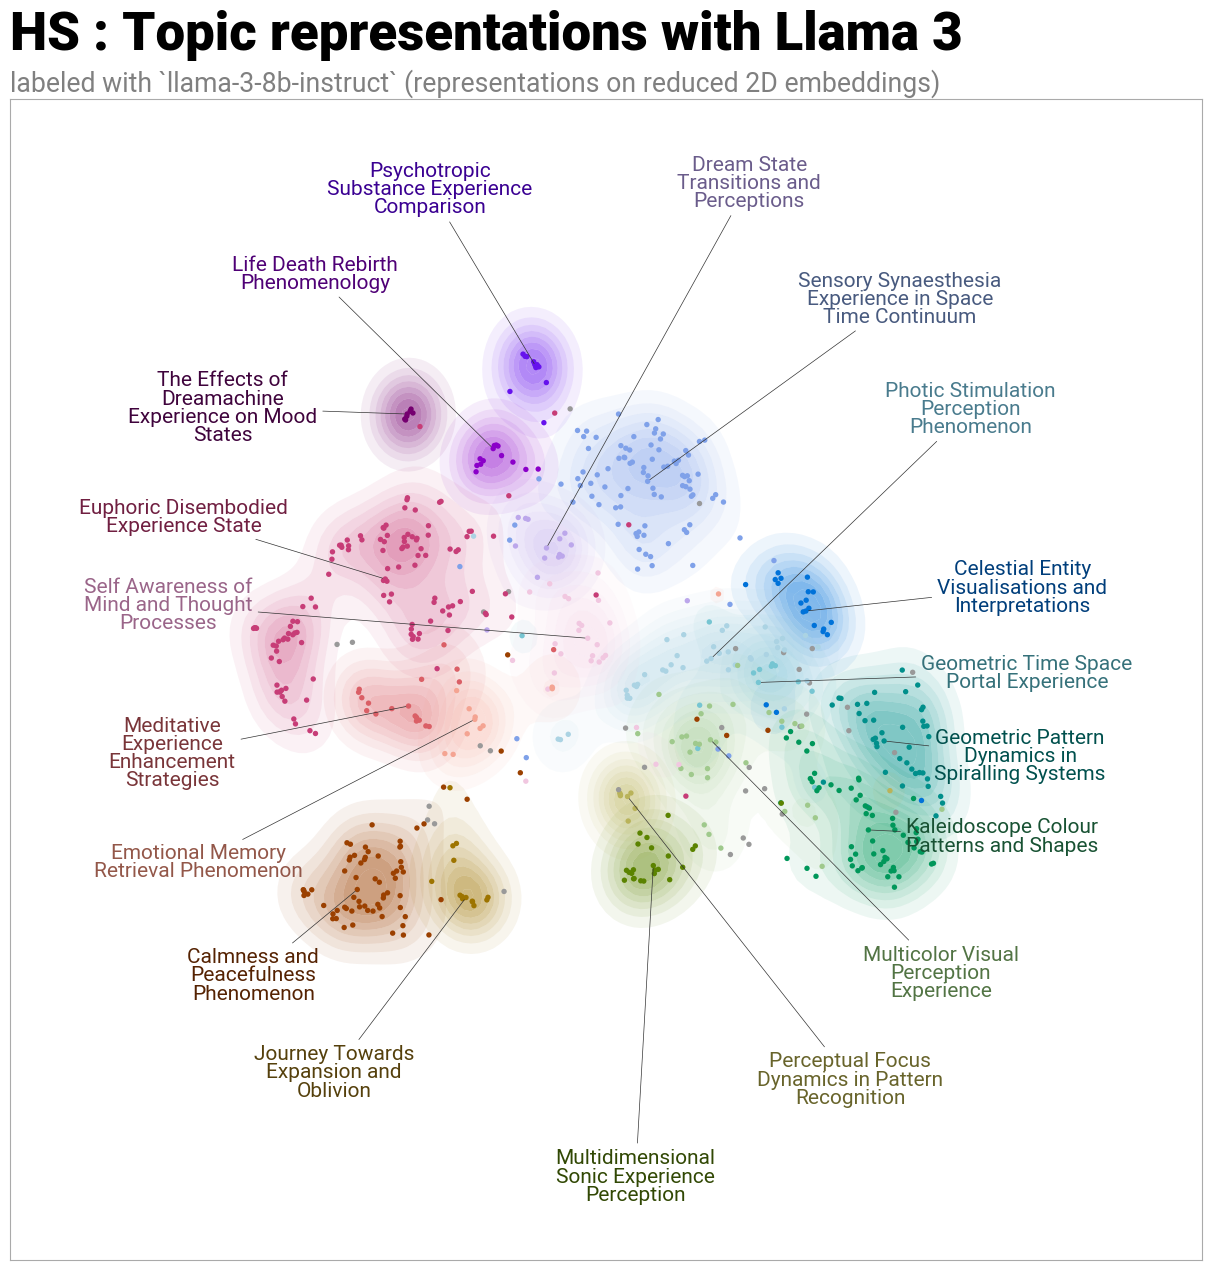

In [32]:
# Run the visualization
datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=15,
   title=f"{condition} : Topic representations with Llama 3",
   sub_title="labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
);

In [33]:

hierarchy_vis = topic_model.visualize_hierarchy(custom_labels=True, color_threshold=.9)
hierarchy_vis

In [34]:
def create_topic_summary(topic_labels, df_reports, topics):
    # Create a dataframe with the topic assignments
    # topics and df_reports should be the same length (682)
    topic_analysis = pd.DataFrame({
        'Topic_Content': df_reports,
        'Topic_Number': topics
    })
    
    # Map the topic numbers to their labels
    # topic_labels is a dictionary with 19 entries
    topic_analysis['Topic_Label'] = topic_analysis['Topic_Number'].map(topic_labels)
    
    # Group and summarize
    topic_summary = (
        topic_analysis
        .groupby(['Topic_Label', 'Topic_Number'])
        .agg({
            'Topic_Content': [
                ('Sentence_Count', 'count'),
                ('Content', list)
            ]
        })
        .reset_index()
    )
    
    # Clean up column names
    topic_summary.columns = ['Topic_Label', 'Topic_Number', 'Sentence_Count', 'Content']
    
    # Sort by sentence count
    topic_summary = topic_summary.sort_values('Sentence_Count', ascending=False)
    
    return topic_summary

# Use the function
topic_summary = create_topic_summary(topic_labels, df_reports, topics)

# Display summary
print("\nSummary DataFrame:")
print(topic_summary[['Topic_Label', 'Topic_Number', 'Sentence_Count']])


Summary DataFrame:
                                          Topic_Label  Topic_Number  \
4               Euphoric Disembodied Experience State             0   
17  Sensory Synaesthesia Experience in Space Time ...             1   
0                Calmness and Peacefulness Phenomenon             2   
8             Kaleidoscope Colour Patterns and Shapes             3   
5    Geometric Pattern Dynamics in Spiralling Systems             5   
14           Photic Stimulation Perception Phenomenon             4   
11            Multicolor Visual Perception Experience            14   
16       Self Awareness of Mind and Thought Processes             7   
12       Multidimensional Sonic Experience Perception             6   
1   Celestial Entity Visualisations and Interpreta...             9   
10       Meditative Experience Enhancement Strategies             8   
2             Dream State Transitions and Perceptions            12   
6              Geometric Time Space Portal Experience    

In [35]:
# After your existing topic modeling code
hierarchical_topics = topic_model.hierarchical_topics(
    docs=df_reports,
    linkage_function=None  # Default is ward
)

# Visualize hierarchy
hierarchical_viz = topic_model.visualize_hierarchy(
    hierarchical_topics=hierarchical_topics,
    custom_labels=True  # Use your LLaMA labels
)

# Get text representation of hierarchy
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

100%|██████████| 18/18 [00:00<00:00, 671.11it/s]

.
├─and_of_colors_saw_shapes
│    ├─■──stars_saw_rapidly_planets_large ── Topic: 9
│    └─and_colors_of_shapes_saw
│         ├─■──shapes_moving_and_if_pink ── Topic: 17
│         └─colors_and_of_shapes_patterns
│              ├─■──geometric_shapes_patterns_spiral_spiraling ── Topic: 5
│              └─colors_and_of_patterns_color
│                   ├─■──colors_and_red_of_kaleidoscope ── Topic: 3
│                   └─■──colors_many_were_of_within ── Topic: 14
└─the_and_was_it_to
     ├─the_was_it_and_felt
     │    ├─music_the_and_sound_it
     │    │    ├─■──music_sound_the_and_seemed ── Topic: 6
     │    │    └─■──focus_back_focused_on_patterns ── Topic: 16
     │    └─was_the_felt_it_to
     │         ├─was_felt_the_it_my
     │         │    ├─it_death_would_do_this
     │         │    │    ├─■──death_life_you_like_rebirth ── Topic: 10
     │         │    │    └─■──do_would_how_could_it ── Topic: 8
     │         │    └─was_felt_the_my_and
     │         │         ├─felt_was_the_o

In [36]:
# Print all merges with their distances, sorted by distance
print("Merge Distances (sorted):")
print(hierarchical_topics[['Parent_Name', 'Child_Left_Name', 'Child_Right_Name', 'Distance']].sort_values('Distance'))

Merge Distances (sorted):
                           Parent_Name  \
0                  felt_was_the_it_and   
1                   felt_was_the_of_it   
2         colors_and_of_patterns_color   
3                  was_felt_the_my_and   
4        colors_and_of_shapes_patterns   
5               music_the_and_sound_it   
6             and_colors_of_shapes_saw   
7               it_death_would_do_this   
8             and_of_colors_saw_shapes   
9                   was_felt_the_it_my   
10  dream_dreaming_machine_quite_sleep   
11                  was_the_felt_it_to   
12  memories_dream_dreaming_machine_my   
13                 the_was_it_and_felt   
14       peace_calm_and_memories_sense   
15       peace_calm_and_sense_memories   
16                   the_and_was_it_to   
17                   and_the_of_was_to   

                               Child_Left_Name  \
0                   experience_felt_it_was_and   
1                          felt_was_the_it_and   
2               colors_an

In [37]:
# For example, to find merges involving visual topics
visual_merges = hierarchical_topics[
    hierarchical_topics['Parent_Name'].str.contains('colors|shapes|geometric', case=False, na=False)
]
print("\nVisual Topic Merges:")
print(visual_merges[['Parent_Name', 'Child_Left_Name', 'Child_Right_Name', 'Distance']])


Visual Topic Merges:
                     Parent_Name                             Child_Left_Name  \
8       and_of_colors_saw_shapes             stars_saw_rapidly_planets_large   
6       and_colors_of_shapes_saw                   shapes_moving_and_if_pink   
4  colors_and_of_shapes_patterns  geometric_shapes_patterns_spiral_spiraling   
2   colors_and_of_patterns_color              colors_and_red_of_kaleidoscope   

                Child_Right_Name  Distance  
8       and_colors_of_shapes_saw  0.832078  
6  colors_and_of_shapes_patterns  0.781861  
4   colors_and_of_patterns_color  0.741569  
2     colors_many_were_of_within  0.633369  


In [38]:
# Print the full hierarchical_topics DataFrame to see all merges
print("Full Hierarchy:")
print(hierarchical_topics[['Parent_Name', 'Child_Left_Name', 'Child_Right_Name', 'Distance', 'Topics']])

Full Hierarchy:
                           Parent_Name  \
17                   and_the_of_was_to   
16                   the_and_was_it_to   
15       peace_calm_and_sense_memories   
14       peace_calm_and_memories_sense   
13                 the_was_it_and_felt   
12  memories_dream_dreaming_machine_my   
11                  was_the_felt_it_to   
10  dream_dreaming_machine_quite_sleep   
9                   was_felt_the_it_my   
8             and_of_colors_saw_shapes   
7               it_death_would_do_this   
6             and_colors_of_shapes_saw   
5               music_the_and_sound_it   
4        colors_and_of_shapes_patterns   
3                  was_felt_the_my_and   
2         colors_and_of_patterns_color   
1                   felt_was_the_of_it   
0                  felt_was_the_it_and   

                               Child_Left_Name  \
17                    and_of_colors_saw_shapes   
16                         the_was_it_and_felt   
15               peace_calm_and_mem

In [39]:
import scipy.cluster.hierarchy as sch
import numpy as np

# First, let's look at what we have
print("Hierarchical Topics structure:")
print(hierarchical_topics.keys())  # This will show us the structure

# Modified function to handle the correct structure
def get_linkage_matrix(hierarchical_topics):
    # Print the structure to understand what we're working with
    print("Keys in hierarchical_topics:", hierarchical_topics.keys())
    
    # Let's see what the first few entries look like
    print("\nFirst few entries:")
    print(hierarchical_topics.head())
    
    return hierarchical_topics

# Get the merging information
linkage_info = get_linkage_matrix(hierarchical_topics)

Hierarchical Topics structure:
Index(['Parent_ID', 'Parent_Name', 'Topics', 'Child_Left_ID',
       'Child_Left_Name', 'Child_Right_ID', 'Child_Right_Name', 'Distance'],
      dtype='object')
Keys in hierarchical_topics: Index(['Parent_ID', 'Parent_Name', 'Topics', 'Child_Left_ID',
       'Child_Left_Name', 'Child_Right_ID', 'Child_Right_Name', 'Distance'],
      dtype='object')

First few entries:
   Parent_ID                    Parent_Name  \
17        36              and_the_of_was_to   
16        35              the_and_was_it_to   
15        34  peace_calm_and_sense_memories   
14        33  peace_calm_and_memories_sense   
13        32            the_was_it_and_felt   

                                               Topics Child_Left_ID  \
17  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...            27   
16  [0, 1, 2, 4, 6, 7, 8, 10, 11, 12, 13, 15, 16, 18]            32   
15                                [2, 11, 12, 15, 18]            33   
14                             

In [40]:
# Print highest level split
print("Highest Level Split:")
print("-----------------")
highest_split = hierarchical_topics.iloc[-1]  # Last row has highest level split
print(f"Distance: {highest_split['Distance']:.3f}")
print(f"Left branch: {highest_split['Child_Left_Name']}")
print(f"Right branch: {highest_split['Child_Right_Name']}")
print(f"Topics involved: {highest_split['Topics']}\n")

# Function to get sub-clusters
def find_subclusters(branch_name):
    subclusters = hierarchical_topics[
        (hierarchical_topics['Parent_Name'].str.contains(branch_name, case=False, na=False)) |
        (hierarchical_topics['Child_Left_Name'].str.contains(branch_name, case=False, na=False)) |
        (hierarchical_topics['Child_Right_Name'].str.contains(branch_name, case=False, na=False))
    ]
    return subclusters

# Analyze visual cluster (and_of_colors)
print("Visual-Perceptual Cluster Analysis:")
print("--------------------------------")
visual_subclusters = find_subclusters('colors|shapes')
print(visual_subclusters[['Parent_Name', 'Child_Left_Name', 'Child_Right_Name', 'Distance', 'Topics']].sort_values('Distance'))

# Analyze experience cluster (the_and_was_it)
print("\nExperience-Emotional Cluster Analysis:")
print("------------------------------------")
experience_subclusters = find_subclusters('was_|felt|peace')
print(experience_subclusters[['Parent_Name', 'Child_Left_Name', 'Child_Right_Name', 'Distance', 'Topics']].sort_values('Distance'))

Highest Level Split:
-----------------
Distance: 0.571
Left branch: experience_felt_it_was_and
Right branch: felt_was_the_through_space
Topics involved: [0, 1]

Visual-Perceptual Cluster Analysis:
--------------------------------
                      Parent_Name                             Child_Left_Name  \
2    colors_and_of_patterns_color              colors_and_red_of_kaleidoscope   
4   colors_and_of_shapes_patterns  geometric_shapes_patterns_spiral_spiraling   
6        and_colors_of_shapes_saw                   shapes_moving_and_if_pink   
8        and_of_colors_saw_shapes             stars_saw_rapidly_planets_large   
17              and_the_of_was_to                    and_of_colors_saw_shapes   

                 Child_Right_Name  Distance  \
2      colors_many_were_of_within  0.633369   
4    colors_and_of_patterns_color  0.741569   
6   colors_and_of_shapes_patterns  0.781861   
8        and_colors_of_shapes_saw  0.832078   
17              the_and_was_it_to  1.159268   



In [41]:
# Function to show cluster details
def analyze_cluster(hierarchical_topics, topic_range, name="Cluster"):
    cluster_data = hierarchical_topics[
        hierarchical_topics['Topics'].apply(lambda x: any(t in topic_range for t in x))
    ]
    
    print(f"\n{name}:")
    print("-" * (len(name) + 1))
    print(f"Topics involved: {topic_range}")
    print("Merging distances:")
    print(cluster_data[['Topics', 'Distance']].sort_values('Distance'))
    print(f"Distance range: {cluster_data['Distance'].min():.3f} - {cluster_data['Distance'].max():.3f}")

# Visual-Perceptual Cluster
visual_topics = [3, 5, 9, 14, 17]
print("\nVISUAL-PERCEPTUAL MAIN CLUSTER")
print("==============================")
# Color-Pattern subcluster
analyze_cluster(hierarchical_topics, [3, 5, 14], "Color-Pattern Subcluster")
# Visual-Movement subcluster
analyze_cluster(hierarchical_topics, [9, 17], "Visual-Movement Subcluster")

# Experience-Emotional Cluster
print("\nEXPERIENCE-EMOTIONAL MAIN CLUSTER")
print("================================")
# Core Experience subcluster
analyze_cluster(hierarchical_topics, [0, 1, 4, 7], "Core Experience Subcluster")
# Altered States subcluster
analyze_cluster(hierarchical_topics, [8, 10, 13], "Altered States Subcluster")
# Memory-Dream subcluster
analyze_cluster(hierarchical_topics, [2, 11, 12, 15, 18], "Memory-Dream Subcluster")

# Overall merge distance
highest_merge = hierarchical_topics['Distance'].max()
print(f"\nHighest level merge distance: {highest_merge:.3f}")


VISUAL-PERCEPTUAL MAIN CLUSTER

Color-Pattern Subcluster:
-------------------------
Topics involved: [3, 5, 14]
Merging distances:
                                               Topics  Distance
2                                             [3, 14]  0.633369
4                                          [3, 5, 14]  0.741569
6                                      [3, 5, 14, 17]  0.781861
8                                   [3, 5, 9, 14, 17]  0.832078
17  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  1.159268
Distance range: 0.633 - 1.159

Visual-Movement Subcluster:
---------------------------
Topics involved: [9, 17]
Merging distances:
                                               Topics  Distance
6                                      [3, 5, 14, 17]  0.781861
8                                   [3, 5, 9, 14, 17]  0.832078
17  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  1.159268
Distance range: 0.782 - 1.159

EXPERIENCE-EMOTIONAL MAIN CLUSTER

Core Experience Subcluster:
---

In [42]:
# Save
import pickle

# Save topic model
topic_model.save("topic_model_HS")

# Save hierarchical topics DataFrame
hierarchical_topics.to_csv("hierarchical_topics_HS.csv")

# Save topic labels if you have custom ones
topic_labels = topic_model.topic_labels_
with open('topic_labels_HS.pkl', 'wb') as f:
    pickle.dump(topic_labels, f)

In [ ]:
#to reload: # Load
# from bertopic import BERTopic
# import pandas as pd
# import pickle

# # Load topic model
# topic_model = BERTopic.load("topic_model_HS")

# # Load hierarchical topics
# hierarchical_topics = pd.read_csv("hierarchical_topics_HS.csv")

# # Load topic labels if you saved them
# with open('topic_labels_HS.pkl', 'rb') as f:
#     topic_labels = pickle.load(f)
#     topic_model.topic_labels_ = topic_labels